In [ ]:
# 基于vllm推理 Kimi-VL-A3B-Instruct

In [1]:
from PIL import Image
from transformers import AutoProcessor
from vllm import LLM, SamplingParams

# model_path = "moonshotai/Kimi-VL-A3B-Instruct"  # or "moonshotai/Kimi-VL-A3B-Thinking"
model_path = "/root/autodl-tmp/moonshotai/Kimi-VL-A3B-Instruct"

llm = LLM(
    model_path,
    trust_remote_code=True,
)

processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

image_path = "/root/Kimi-VL/figures/demo.png"
image = Image.open(image_path)
messages = [
    {"role": "user", "content": [{"type": "image", "image": image_path}, {"type": "text", "text": "What is the dome building in the picture? Think step by step."}]}
]
text = processor.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
outputs = llm.generate([{"prompt": text, "multi_modal_data": {"image": image}}], sampling_params = SamplingParams(max_tokens=512))

print("-" * 50)
for o in outputs:
    generated_text = o.outputs[0].text
    print(generated_text)
    print("-" * 50)

INFO 05-20 09:58:59 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-20 09:58:59 [__init__.py:239] Automatically detected platform cuda.
INFO 05-20 09:59:07 [config.py:717] This model supports multiple tasks: {'score', 'embed', 'reward', 'generate', 'classify'}. Defaulting to 'generate'.
INFO 05-20 09:59:07 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 05-20 09:59:09 [tokenizer.py:251] Using a slow tokenizer. This might cause a significant slowdown. Consider using a fast tokenizer instead.
INFO 05-20 09:59:09 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='/root/autodl-tmp/moonshotai/Kimi-VL-A3B-Instruct', speculative_config=None, tokenizer='/root/autodl-tmp/moonshotai/Kimi-VL-A3B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None,

Loading safetensors checkpoint shards:   0% Completed | 0/7 [00:00<?, ?it/s]


INFO 05-20 09:59:23 [loader.py:458] Loading weights took 9.77 seconds
INFO 05-20 09:59:24 [gpu_model_runner.py:1347] Model loading took 30.6134 GiB and 10.137529 seconds
INFO 05-20 09:59:24 [gpu_model_runner.py:1620] Encoder cache will be initialized with a budget of 8192 tokens, and profiled with 8 image items of the maximum feature size.
INFO 05-20 09:59:30 [backends.py:420] Using cache directory: /root/.cache/vllm/torch_compile_cache/65cbc9337e/rank_0_0 for vLLM's torch.compile
INFO 05-20 09:59:30 [backends.py:430] Dynamo bytecode transform time: 5.65 s
INFO 05-20 09:59:32 [backends.py:136] Cache the graph of shape None for later use
INFO 05-20 09:59:52 [backends.py:148] Compiling a graph for general shape takes 21.38 s
WARNING 05-20 09:59:55 [fused_moe.py:668] Using default MoE config. Performance might be sub-optimal! Config file not found at /root/miniconda3/lib/python3.12/site-packages/vllm/model_executor/layers/fused_moe/configs/E=64,N=1408,device_name=NVIDIA_L20.json
INFO 05-2

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

--------------------------------------------------
To identify the dome building in the picture, we can follow these steps:

1. **Observe the Image**: The image shows a cityscape with several notable buildings, including a distinctive dome structure.

2. **Focus on the Dome Building**: The dome building is centrally located in the image and has a unique, rounded roof that stands out from the surrounding structures.

3. **Identify Key Features**: The dome is large and white, with a transparent section in the middle, suggesting it is used for public events or gatherings.

4. **Contextual Clues**: The building is situated in an area with high-rise buildings and a major tower in the background, indicating it is in a prominent location within the city.

5. ** Recognition**: Based on the distinctive dome and its location, the building in the image is the Rogers Centre, a well-known sports and convention venue in Toronto, Canada.

By carefully analyzing the features and context of the buildin

# 发布OpenAI 兼容服务器

```bash
vllm serve /root/autodl-tmp/moonshotai/Kimi-VL-A3B-Instruct --served-model-name kimi-vl --trust-remote-code --tensor-parallel-size 1 --max-num-batched-tokens 32768 --max-model-len 32768 --limit-mm-per-prompt image=8

```
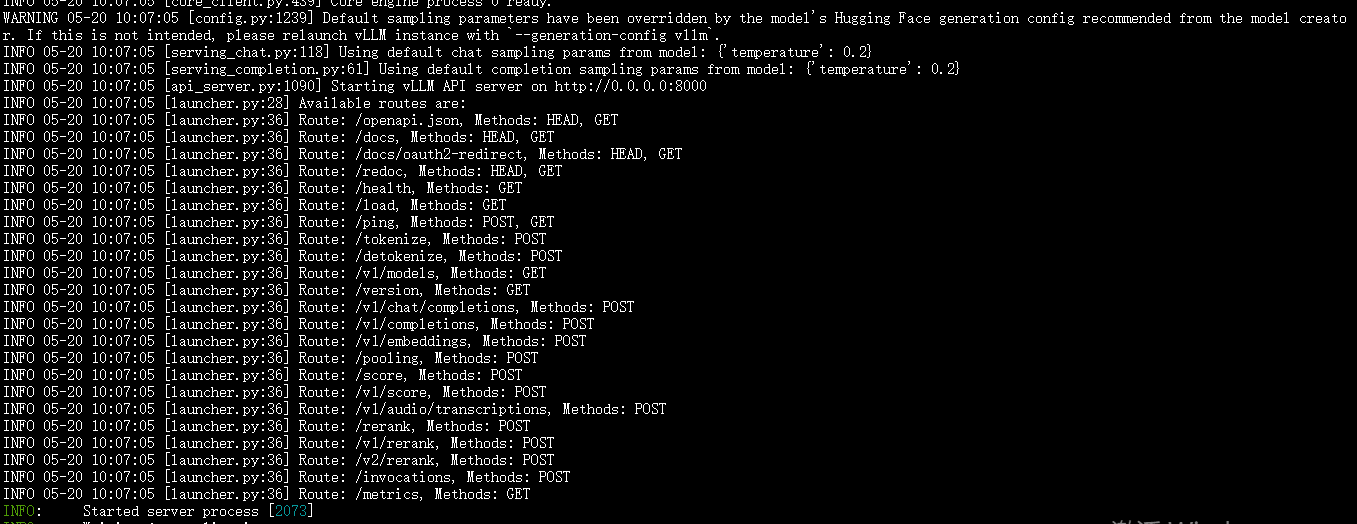

# 调用 OpenAI 兼容的 API

In [2]:
import base64
from PIL import Image
from io import BytesIO
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="token-abc123",
)

image_path = "/root/Kimi-VL/figures/demo.png"
image = Image.open(image_path).convert("RGB")

buffered = BytesIO()
image.save(buffered, format="JPEG")
img_b64_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
base64_image_url = f"data:image/jpeg;base64,{img_b64_str}"

messages = [
    {"role": "user", "content": [{"type": "image_url", "image_url": {"url": base64_image_url}}, {"type": "text", "text": "What is the dome building in the picture? Think step by step."}]}
]

completion = client.chat.completions.create(
  model="kimi-vl",
  messages=messages
)

print(completion.choices[0].message)

[2025-05-20 10:15:44] INFO _client.py:1038: HTTP Request: POST http://localhost:8000/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='To identify the dome building in the picture, we need to analyze the visual characteristics and context provided by the image. Here are the detailed steps:\n\n1. **Observation of the Building**: The building in question has a distinctive white dome structure. This dome is a key feature that can help in identifying the building.\n\n2. **Location Context**: The image shows a cityscape with a tall tower in the background, which is the CN Tower. This helps narrow down the location to Toronto, Canada.\n\n3. **Building Identification**: The white dome building is located near the CN Tower and has a unique architectural style. This building is known as the Rogers Centre, which is a multi-purpose stadium in downtown Toronto.\n\n4. **Confirmation**: The Rogers Centre is indeed home to the Toronto Blue Jays (baseball) and the Toronto Argonauts (football), which further confirms its identity.\n\nBy combining the visual characteristics of the dome and the contextual 